<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" style="height:90px;" width=500/></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

В этом ноутбке мы научимся писать свои свёрточные нейросети на фреймворке PyTorch, и протестируем их работу на датасетах MNIST и CIFAR10. 

**ВНИМАНИЕ:** Рассматривается ***задача классификации изображений***.

(Подразумевается, что читатель уже знаком с многослойной нейроннной сетью).  

***Свёрточная нейросеть (Convolutional Neural Network, CNN)*** - это многослойная нейросеть, имеющая в своей архитектуре помимо *полносвязных слоёв* (а иногда их может и не быть) ещё и **свёрточные слои (Conv Layers)** и **pooling-слои (Pool Layers)**.  

Собственно, название такое эти сети получили потому, что в основе их работы лежит операция **свёртки**. 


Сразу же стоит сказать, что свёрточные нейросети **были придуманы прежде всего для задач, связанных с картинками**, следовательно, на вход они тоже "ожидают" картинку.

Расмотрим их устройство более подробно:

* Вот так выглядит неглубокая свёрточная нейросеть, имеющая такую архитектуру:  
`Input -> Conv 5x5 -> Pool 2x2 -> Conv 5x5 -> Pool 2x2 -> FC -> Output`

<img src="https://camo.githubusercontent.com/269e3903f62eb2c4d13ac4c9ab979510010f8968/68747470733a2f2f7261772e6769746875622e636f6d2f746176677265656e2f6c616e647573655f636c617373696669636174696f6e2f6d61737465722f66696c652f636e6e2e706e673f7261773d74727565" width=800, height=600>

Свёрточные нейросети (обыкновенные, есть и намного более продвинутые) почти всегда строятся по следующему правилу:  

`INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC`  

то есть:  

1). ***Входной слой*** (batch картинок `HxWxC`)  

2). $M$ блоков (M $\ge$ 0) из свёрток и pooling-ов, причём именно в том порядке, как в формуле выше. Все эти $M$ блоков вместе называют ***feature extractor*** свёрточной нейросети, потому что эта часть сети отвечает непосредственно за формирование новых, более сложных признаков, поверх тех, которые подаются (то есть, по аналогии с MLP, мы опять же переходим к новому признаковому пространству, однако здесь оно строится сложнее, чтем в обычных многослойных сетях, поскольку используется операция свёртки)  

3). $K$ штук FullyConnected-слоёв (с активациями). Эту часть из $K$ FC-слоёв называют ***classificator***, поскольку эти слои отвечают непосредственно за предсказание нужно класса (сейчас рассматривается задача классификации изображений).


<h3 style="text-align: center;"><b>Свёрточная нейросеть на PyTorch</b></h3>

Ешё раз напомним про основные компоненты нейросети:

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количетсво итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

Так как мы сейчас рассматриваем **архитектуру CNN**, то, помимо этих компонент, в свёрточной нейросети можно настроить следующие вещи:  

- (в каждом ConvLayer) **размер фильтров (окна свёртки)** (`kernel_size`)
- (в каждом ConvLayer) **количество фильтров** (`out_channels`)  
- (в каждом ConvLayer) размер **шага окна свёртки (stride)** (`stride`)  
- (в каждом ConvLayer) **тип padding'а** (`padding`)  


- (в каждом PoolLayer) **размер окна pooling'a** (`kernel_size`)  
- (в каждом PoolLayer) **шаг окна pooling'а** (`stride`)  
- (в каждом PoolLayer) **тип pooling'а** (`pool_type`)  
- (в каждом PoolLayer) **тип padding'а** (`padding`)

Какими их берут обычно -- будет показано в примере ниже. По крайней мере, можете стартовать с этих настроек, чтобы понять, какое качество "из коробки" будет у простой модели.

Посмотрим, как работает CNN на MNIST'е и на CIFAR'е.

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline

# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

<img src="http://present5.com/presentation/20143288_415358496/image-8.jpg" width=500, height=400>

**MNIST:** это набор из 70k картинок рукописных цифр от 0 до 9, написанных людьми, 60k из которых являются тренировочной выборкой (`train` dataset)), и ещё 10k выделены для тестирования модели (`test` dataset).

Скачаем и загрузим в `loader`'ы:

**Обратите внимание на аргумент `batch_size`:** именно он будет отвечать за размер батча, который будет подаваться при оптимизации нейросети

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

Сами данные лежат в полях `trainloader.dataset.train_data` и `testloader.dataset.test_data`:

In [3]:
trainloader.dataset.train_data.shape

/Users/timur/.pyenv/versions/3.7.10/lib/python3.7/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])

In [4]:
testloader.dataset.test_data.shape

/Users/timur/.pyenv/versions/3.7.10/lib/python3.7/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


torch.Size([10000, 28, 28])

Выведем первую картинку:

In [5]:
trainloader.dataset.train_data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

Посмотрим, как она выглядит:

In [6]:
# преобразовать тензор в np.array
numpy_img = trainloader.dataset.train_data[0].numpy()

In [7]:
numpy_img.shape

(28, 28)

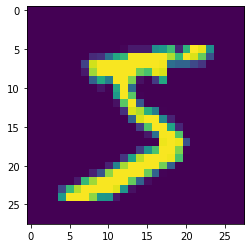

In [8]:
plt.imshow(numpy_img);

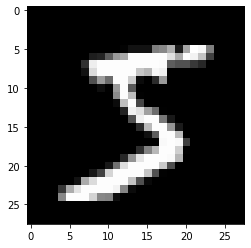

In [9]:
plt.imshow(numpy_img, cmap='gray');

Отрисовка заданной цифры:

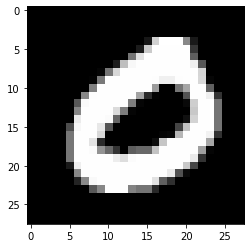

In [10]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=60000)

plt.imshow(trainloader.dataset.train_data[i].numpy(), cmap='gray');

Как итерироваться по данным с помощью `loader'`а? Очень просто:

In [11]:
for data in trainloader:
    print(data)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
   

То есть мы имеем дело с кусочками данных размера batch_size (в данном случае = 4), причём в каждом батче есть как объекты, так и ответы на них (то есть и $X$, и $y$).

Теперь вернёмся к тому, что в PyTorch есть две "парадигмы" построения нейросетей -- `Functional` и `Seuquential`. Со второй мы уже хорошенько разобрались в предыдущих ноутбуках по нейросетям, теперь мы испольузем именно `Functional` парадигму, потому что при построении свёрточных сетей это намного удобнее:

In [12]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [13]:
# ЗАМЕТЬТЕ: КЛАСС НАСЛЕДУЕТСЯ ОТ nn.Module
class SimpleConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(SimpleConvNet, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)  # !!!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 4 * 4 * 16)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
net = SimpleConvNet()

summary(net, (1,28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 120]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


In [17]:
batch = []


batch = next(iter(trainloader))

net.forward(torch.FloatTensor(batch[0]))

tensor([[ 0.0673, -0.0202,  0.0880, -0.1096,  0.1048, -0.0668, -0.0571,  0.0770,
          0.0914,  0.1054],
        [ 0.0663, -0.0164,  0.0882, -0.1125,  0.0974, -0.0670, -0.0553,  0.0809,
          0.1009,  0.1128],
        [ 0.0706, -0.0147,  0.0843, -0.1179,  0.0982, -0.0692, -0.0587,  0.0749,
          0.0983,  0.1110],
        [ 0.0520, -0.0229,  0.0785, -0.1123,  0.1011, -0.0762, -0.0607,  0.0741,
          0.0988,  0.1124]], grad_fn=<AddmmBackward0>)

**Важное примечание:** Вы можете заметить, что в строчках с `#!!!` есть не очень понятный сходу 4 `*` 4 `*` 16. Это -- размерность картинки перед FC-слоями (H x W x C), тут её приходиться высчитывать вручную (в Keras, например, `.Flatten()` всё делает за Вас). Однако есть один *лайфхак* -- просто сделайте в `forward()` `print(x.shape)` (закомментированная строка). Вы увидите размер `(batch_size, C, H, W)` -- нужно перемножить все, кроме первого (batch_size), это и будет первая размерность `Linear()`, и именно в C * H * W нужно "развернуть" x перед подачей в `Linear()`.  

То есть нужно будет запустить цикл с обучением первый раз с `print()` и сделать после него `break`, посчитать размер, вписать его в нужные места и стереть `print()` и `break`.

Код обучения слоя:

In [18]:
from tqdm import tqdm_notebook

In [19]:
# объявляем сеть
net = SimpleConvNet().to(device)

In [20]:
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
losses = []

In [21]:
cnt = 0
temp = 0
for i, batch in enumerate(tqdm_notebook(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        cnt = i
        if i % 2000 == 1999:
          temp += 1 
cnt,temp

/Users/timur/.pyenv/versions/3.7.10/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/15000 [00:00<?, ?it/s]

(14999, 7)

/Users/timur/.pyenv/versions/3.7.10/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/2 [00:00<?, ?it/s]

/Users/timur/.pyenv/versions/3.7.10/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 0.983
[1,  4000] loss: 0.368
[1,  6000] loss: 0.285
[1,  8000] loss: 0.251
[1, 10000] loss: 0.204
[1, 12000] loss: 0.174
[1, 14000] loss: 0.157


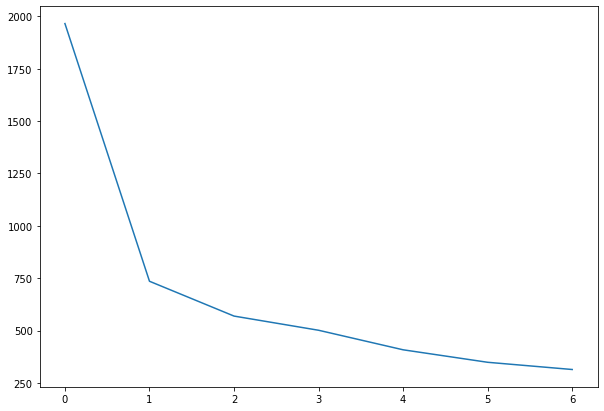

/Users/timur/.pyenv/versions/3.7.10/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.132
[2,  4000] loss: 0.131
[2,  6000] loss: 0.120
[2,  8000] loss: 0.122
[2, 10000] loss: 0.111
[2, 12000] loss: 0.100
[2, 14000] loss: 0.103
Обучение закончено


In [22]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)

# итерируемся
for epoch in tqdm_notebook(range(2)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выведем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            losses.append(running_loss)
            running_loss = 0.0

    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    plt.show()

print('Обучение закончено')

Протестируем на всём тестовом датасете, используя метрику accuracy_score:

In [24]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        
        c = (predicted.cpu().detach() == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 95 %
Accuracy of     4 : 98 %
Accuracy of     5 : 99 %
Accuracy of     6 : 98 %
Accuracy of     7 : 95 %
Accuracy of     8 : 95 %
Accuracy of     9 : 95 %


---

### Задача 1

Протестируйте эту нейросеть на отдельных картинках из тестового датасета: напишите функцию, которая принимает индекс картинки в тестовом датасете, отрисовывает её, потом запускает на ней модель (нейросеть) и выводит результат предсказания.

---

<h3 style="text-align: center;"><b>CIFAR10</b></h3>

<img src="https://raw.githubusercontent.com/soumith/ex/gh-pages/assets/cifar10.png" width=500, height=400>

**CIFAR10:** это набор из 60k картинок 32х32х3, 50k которых составляют обучающую выборку, и оставшиеся 10k - тестовую. Классов в этом датасете 10: `'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'`.

Скачаем и загрузим в `loader`'ы:

**Обратите внимание на аргумент `batch_size`:** именно он будет отвечать за размер батча, который будет подаваться при оптимизации нейросети

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


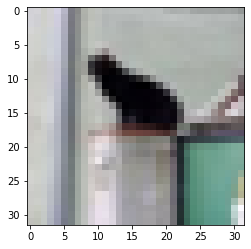

In [ ]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=50000)

plt.imshow(trainloader.dataset.data[i], cmap='gray');

То есть мы имеем дело с кусочками данных размера batch_size (в данном случае = 4), причём в каждом батче есть как объекты, так и ответы на них (то есть и $X$, и $y$).

Данные готовы, мы даже на них посмотрели.

К делу:

### Задача 2

Напишите свою свёрточную нейросеть для предсказания на CIFAR10.

In [ ]:
next(iter(trainloader))[0].shape

torch.Size([128, 3, 32, 32])

In [ ]:
class MyConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super().__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.fc1 = nn.Linear(6 * 6 * 128, 128)  # !!!
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        #(32,32)
        x = self.pool(F.relu(self.conv1(x)))
        #(14,14)
        x = self.pool(F.relu(self.conv2(x)))
        #(6,6)
        #print(x.shape)
        x = x.view(-1, 6 * 6 * 128)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Обучим:

In [ ]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

net = MyConvNet().to(device)

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm_notebook(range(10)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выводем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app




Обучение закончено


Посмотрим на accuracy на тестовом датасете:

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images.to(device))#.view(4, -1))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted.cpu().detach() == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 55 %
Accuracy of   car : 71 %
Accuracy of  bird : 54 %
Accuracy of   cat : 41 %
Accuracy of  deer : 29 %
Accuracy of   dog : 21 %
Accuracy of  frog : 69 %
Accuracy of horse : 68 %
Accuracy of  ship : 78 %
Accuracy of truck : 56 %


Как думаете, этого достаточно?

### Задача 3  

Улучшите свёрточную нейросеть: поэкспериментируйте с архитектурой (количество слоёв, порядок слоёв), с гиперпараметрами слоёв (размеры kernel_size, размеры pooling'а, количество kernel'ов в свёрточном слое) и с гиперпараметрами, указанными в "Компоненты нейросети" (см. памятку выше).

In [ ]:
# Ваш код здесь

(Ожидаемый результат -- скорее всего, сходу Вам не удастся выжать из Вашей сетки больше, чем ~70% accuracy (в среднем по всем классам). Если это что-то в этом районе - Вы хорошо постарались).

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам свёрточных нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/convolutional-networks/  
http://cs231n.github.io/understanding-cnn/  
http://cs231n.github.io/transfer-learning/

4). Видео о Computer Vision от Andrej Karpathy: https://www.youtube.com/watch?v=u6aEYuemt0M